## Import libraries

In [1]:
import sys
import pandas as pd
import math
import numpy as np
import operator
import collections

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


## Scatter functions

In [2]:
# Define our own plot function
def scatter(x, labels, x_min, y_min, x_max, y_max, margin=0, subtitle=None):
    # We choose a color palette with seaborn.
    num_of_labels = int(len(labels))
    palette = np.array(sns.color_palette("hls", num_of_labels+1))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    
    
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(x_min,x_max)
    plt.ylim(y_min,y_max)
    # 그래프 규격선, 여백공간 제거
    #ax.axis('off') 
    #ax.axis('tight')

    # text
    c_count={}
    for c in labels:
        if c == num_of_labels:
            continue
        try: c_count[c]+= 1
        except: c_count[c]=1
    txts = []
    for key in c_count.keys():
        if c_count[key]<margin:
            continue
        
        # Add Label with txt type on plotting image
        xtext, ytext = np.median(x[labels == key, :], axis=0)
        txt = ax.text(xtext, ytext, str(key), fontsize=10)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=3, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    
    # draw margin range
    ax.add_patch(plt.Circle((0,0), margin, fc='b', ec='b'))
    
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig('result.png')
    

## DBSCAN

In [3]:
class DBSCAN:
    def __init__(self, n, Eps, MinPts,):
        self.n = n
        self.Eps = Eps
        self.MinPts = MinPts
        
    def load_dataset(self, filename='../data/data/input1.txt'):
        self.dataset_df_raw = pd.read_csv(filename, names=['id','x','y'], header=None, delimiter='\t')
        dataset_df_sorted = self.dataset_df_raw.sort_values(['x'], ascending=[True])
        self.dataset = dataset_df_sorted.to_dict('records')                                             # dataset[idx]

        self.x_max, self.y_max = self.dataset_df_raw.max(axis=0)[['x','y']]
        self.x_min, self.y_min = self.dataset_df_raw.min(axis=0)[['x','y']]
        
        
        self.root = [i for i in range(len(self.dataset))]                                                    # root[id]
        self.adjs = [[] for _ in range(len(self.dataset))]                                                   # adjs[id]

    def get_square_distance(self, p_0, p_1):
        return (p_0['x']-p_1['x'])*(p_0['x']-p_1['x']) + (p_0['y']-p_1['y'])*(p_0['y']-p_1['y'])

    def get_root(self, pid):
        if self.root[pid] == pid:
            return self.root[pid]
        self.root[pid] = self.get_root(self.root[pid])
        return self.root[pid]
    
    def set_adjs(self):
        idx_start = 0
        for p_now in self.dataset:
            # update idx_start
            for p_adj in self.dataset[idx_start:]:
                if p_now['x'] - p_adj['x'] > self.Eps:
                    idx_start += 1
                else: 
                    break
            # calc the num of pts
            for p_adj in self.dataset[idx_start:]:
                if p_adj['x'] - p_now['x'] > self.Eps:
                    break
                if self.get_square_distance(p_now, p_adj) <= self.Eps * self.Eps:
                    self.adjs[p_now['id']].append(p_adj)

    def cluster_adjs(self):
        for p_now in self.dataset:
            # check if core
            if len(self.adjs[p_now['id']]) >= self.MinPts:
        
                # reset root
                root_now = p_now['id']
                self.root[self.get_root(root_now)] = root_now
                self.root[root_now] = root_now
        
                # update adj points. to point to p_now
                for p_adj in self.adjs[p_now['id']]:
                    root_adj = p_adj['id']
                    if len(self.adjs[root_adj]) >= self.MinPts:
                        root_adj = self.get_root(root_adj)
                    self.root[root_adj] = root_now
                    
        # change parent of node to root of node
        self.cluster = [[] for _ in range(len(self.root))]
        for idx in range(len(self.root)):
            self.root[idx] = self.get_root(idx)
            self.cluster[self.root[idx]].append(idx)

    def save_clusters(self, filename='input1'):
        # get sort cluster by size
        cluster_sorted = collections.Counter(self.root).most_common()
        for idx, (label, _) in enumerate(cluster_sorted[:self.n]):
            # pd.DataFrame(self.cluster[label]).to_csv(filename+'_cluster_'+str(idx)+'.txt')
            np.savetxt(filename+'_cluster_'+str(idx)+'.txt', self.cluster[label], fmt='%d')
            
            
        
    def scatter_result(self, margin = 0, scatter_function = scatter, filename='result1.png'):
        # set points
        points = self.dataset_df_raw[['x', 'y']].to_dict('records')
        points = [[point['x'], point['y']] for point in points]
        points = np.array(points)
                
        # cut small cluster with margin
        for idx in range(len(self.root)):
            if len(self.cluster[self.root[idx]]) < margin:
                self.root[idx]=len(self.root)
        self.root = np.array(self.root)
        
        # scatter
        scatter(points, self.root, self.x_min, self.y_min, self.x_max, self.y_max, margin, filename)

            

### run examples

##### 1. input1.txt     
- n=8 
- Eps=15
- MinPts=22

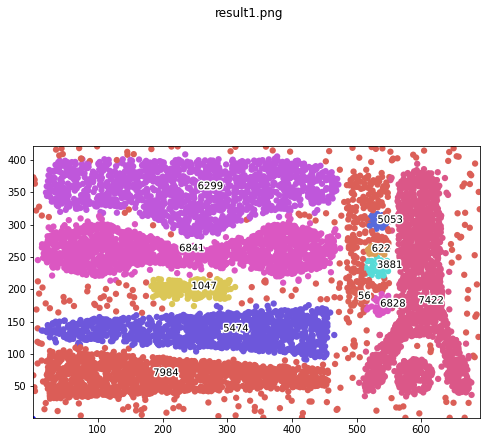

In [4]:
model = DBSCAN(n=8, Eps=15, MinPts=22)
model.load_dataset(filename='../data/data/input1.txt')
model.set_adjs()
model.cluster_adjs()
model.save_clusters(filename='input1')

model.scatter_result(margin=3, filename='result1.png')

##### 2. input2.txt
- n=5 
- Eps=2 
- MinPts=7

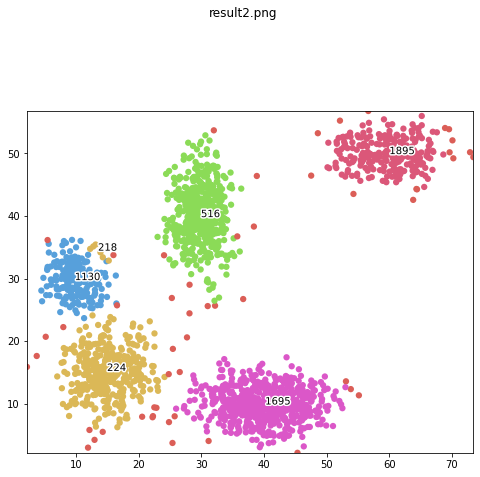

In [5]:
model = DBSCAN(n=5, Eps=2, MinPts=7)
model.load_dataset(filename='../data/data/input2.txt')
model.set_adjs()
model.cluster_adjs()
model.save_clusters(filename='input2')

model.scatter_result(margin=3, filename='result2.png')

##### input3.txt
- n=4
- Eps=5
- MinPts=5

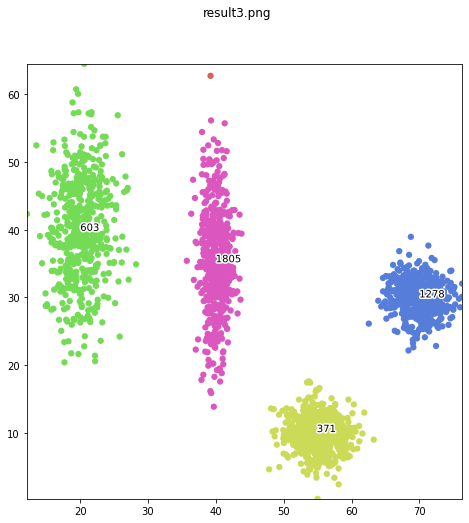

In [6]:
model = DBSCAN(n=4, Eps=5, MinPts=5)
model.load_dataset(filename='../data/data/input3.txt')
model.set_adjs()
model.cluster_adjs()
model.save_clusters(filename='input3')

model.scatter_result(margin=3, filename='result3.png')

##### 4. input1.txt 
- n=8   
- Eps=8.815    
- MinPts=6

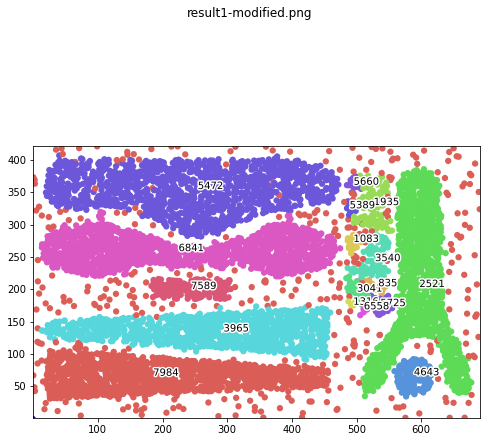

In [7]:
model = DBSCAN(n=8, Eps=8.815, MinPts=6)
model.load_dataset(filename='../data/data/input1.txt')
model.set_adjs()
model.cluster_adjs()
model.save_clusters(filename='input1')

model.scatter_result(margin=3, filename='result1-modified.png')